In [2]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 12.3 MB/s eta 0:00:00a 0:00:01


In [4]:
!pip install s3fs

  Using cached s3fs-2024.6.1-py3-none-any.whl.metadata (1.6 kB)
  Using cached fsspec-2024.6.1-py3-none-any.whl.metadata (11 kB)
Using cached s3fs-2024.6.1-py3-none-any.whl (29 kB)
Using cached fsspec-2024.6.1-py3-none-any.whl (177 kB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2023.6.0
    Uninstalling fsspec-2023.6.0:
      Successfully uninstalled fsspec-2023.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-ai 2.18.1 requires faiss-cpu, which is not installed.
datasets 2.20.0 requires fsspec[http]<=2024.5.0,>=2023.1.0, but you have fsspec 2024.6.1 which is incompatible.
jupyter-scheduler 2.7.1 requires fsspec==2023.6.0, but you have fsspec 2024.6.1 which is incompatible.


In [37]:
import re
import boto3
import time
import shap
import s3fs
import pandas as pd
import numpy as np
from io import BytesIO

In [6]:
s3 = boto3.client('s3')

bucket_name = "sagemaker-studio-619071335465-gekmibeales"
file_key = 'storedata_total.csv'

s3_object = s3.get_object(Bucket=bucket_name, Key=file_key)
file_content = s3_object['Body'].read()

df = pd.read_csv(BytesIO(file_content))
df.head()

,custid,retained,created,firstorder,lastorder,esent,eopenrate,eclickrate,avgorder,ordfreq,paperless,refill,doorstep,favday,city
0,6H6T6N,0,9/28/2012,8/11/2013,8/11/2013,29,100.000000,3.448276,14.52,0.000000,0,0,0,Monday,DEL
1,APCENR,1,12/19/2010,4/1/2011,1/19/2014,95,92.631579,10.526316,83.69,0.181641,1,1,1,Friday,DEL
2,7UP6MS,0,10/3/2010,12/1/2010,7/6/2011,0,0.000000,0.000000,33.58,0.059908,0,0,0,Wednesday,DEL
3,7ZEW8G,0,10/22/2010,3/28/2011,3/28/2011,0,0.000000,0.000000,54.96,0.000000,0,0,0,Thursday,BOM
4,8V726M,1,11/27/2010,11/29/2010,1/28/2013,30,90.000000,13.333333,111.91,0.008850,0,0,0,Monday,BOM


In [7]:
df.shape

(30801, 15)

In [8]:
def preprocess_data(df):
    df["firstorder"] = pd.to_datetime(df["firstorder"], errors='coerce')
    df["lastorder"] = pd.to_datetime(df["lastorder"], errors='coerce')
    df = df.dropna()
    df["first_last_days_diff"] = (df['lastorder']-df['firstorder']).dt.days
    df['created'] = pd.to_datetime(df['created'])
    df['created_first_days_diff'] = (df['created']-df['firstorder']).dt.days
    df.drop(['custid', 'created', 'firstorder', 'lastorder'], axis=1, inplace=True)
    df = pd.get_dummies(df, prefix=['favday', 'city'], columns=['favday', 'city'])
    return df


In [9]:
model_name = "churn_model"
env = "dev"

storedata = preprocess_data(df)
storedata.head()

/tmp/ipykernel_172/23204581.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["first_last_days_diff"] = (df['lastorder']-df['firstorder']).dt.days
/tmp/ipykernel_172/23204581.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['created'] = pd.to_datetime(df['created'])
/tmp/ipykernel_172/23204581.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

,retained,esent,eopenrate,eclickrate,avgorder,ordfreq,paperless,refill,doorstep,first_last_days_diff,...,favday_Monday,favday_Saturday,favday_Sunday,favday_Thursday,favday_Tuesday,favday_Wednesday,city_BLR,city_BOM,city_DEL,city_MAA
0,0,29,100.000000,3.448276,14.52,0.000000,0,0,0,0,...,True,False,False,False,False,False,False,False,True,False
1,1,95,92.631579,10.526316,83.69,0.181641,1,1,1,1024,...,False,False,False,False,False,False,False,False,True,False
2,0,0,0.000000,0.000000,33.58,0.059908,0,0,0,217,...,False,False,False,False,False,True,False,False,True,False
3,0,0,0.000000,0.000000,54.96,0.000000,0,0,0,0,...,False,False,False,True,False,False,False,True,False,False
4,1,30,90.000000,13.333333,111.91,0.008850,0,0,0,791,...,True,False,False,False,False,False,False,True,False,False


In [10]:
storedata.shape

(30758, 22)

In [11]:
def split_datasets(df):
    y=df.pop("retained")
    X_pre = df
    y_pre = y.to_numpy().reshape(len(y),1)
    feature_names = list(X_pre.columns)
    X= np.concatenate((y_pre,X_pre),axis=1)
    np.random.shuffle(X)
    train,validation,test=np.split(X,[int(.7*len(X)),int(.85*len(X))])
    return feature_names,train,validation,test


feature_names,train,validation,test = split_datasets(storedata)

In [12]:
df_train = pd.DataFrame(train)
df_train.to_csv('train.csv', header=False, index=False)
s3.upload_file('train.csv', Bucket=bucket_name, Key='data/train/train.csv')

df_validation = pd.DataFrame(validation)
df_validation.to_csv('validation.csv', header=False, index=False)
s3.upload_file('validation.csv', Bucket=bucket_name, Key='data/validation/validation.csv')

df_test = pd.DataFrame(test)
df_test.to_csv('test.csv', header=False, index=False)
s3.upload_file('test.csv', Bucket=bucket_name, Key='data/test/test.csv')

In [13]:
from sagemaker.inputs import TrainingInput

s3_input_train = TrainingInput(
    s3_data=f"s3://{bucket_name}/data/train/", content_type="csv"
)

s3_input_validation = TrainingInput(
    s3_data=f"s3://{bucket_name}/data/validation/", content_type="csv"
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [14]:
import sagemaker

region = boto3.Session().region_name
role = sagemaker.get_execution_role()

In [15]:

from sagemaker.tuner import HyperparameterTuner, ContinuousParameter, IntegerParameter


fixed_hyperparameters = {
    "eval_metric":"auc",
    "objective":"binary:logistic",
    "num_round":100,
    "rate_drop":"0.3",
    "tweedie_variance_power":"1.4"
}


sess = sagemaker.Session()
container = sagemaker.image_uris.retrieve("xgboost",region,"0.90-2")

estimator = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    hyperparameters=fixed_hyperparameters,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/output".format(bucket_name),
    sagemaker_session=sess
)


hyperparameter_ranges = {
    "eta": ContinuousParameter(0, 1),
    "min_child_weight": ContinuousParameter(1, 10),
    "alpha": ContinuousParameter(0, 2),
    "max_depth": IntegerParameter(1, 10),
}
objective_metric_name = "validation:auc"
tuner = HyperparameterTuner(
estimator, objective_metric_name,
hyperparameter_ranges,max_jobs=10,max_parallel_jobs=2)


tuner.fit({
    "train":s3_input_train,
    "validation":s3_input_validation
    },include_cls_metadata=False)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.......................................................................!


In [16]:
tuning_job_result = boto3.client("sagemaker").describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name
)

job_count = tuning_job_result["TrainingJobStatusCounters"]["Completed"]
print("%d training jobs have completed" %job_count)


from pprint import pprint
if tuning_job_result.get("BestTrainingJob",None):
    print("Best Model found so far:")
    pprint(tuning_job_result["BestTrainingJob"])
else:
    print("No training jobs have reported results yet.")

10 training jobs have completed
Best Model found so far:
{'CreationTime': datetime.datetime(2024, 8, 20, 15, 58, 49, tzinfo=tzlocal()),
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:auc',
                                                 'Value': 0.9789209961891174},
 'ObjectiveStatus': 'Succeeded',
 'TrainingEndTime': datetime.datetime(2024, 8, 20, 15, 59, 22, tzinfo=tzlocal()),
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-2:619071335465:training-job/sagemaker-xgboost-240820-1553-009-3b252f4e',
 'TrainingJobName': 'sagemaker-xgboost-240820-1553-009-3b252f4e',
 'TrainingJobStatus': 'Completed',
 'TrainingStartTime': datetime.datetime(2024, 8, 20, 15, 58, 53, tzinfo=tzlocal()),
 'TunedHyperParameters': {'alpha': '1.0174423140948692',
                          'eta': '0.04899881791072591',
                          'max_depth': '9',
                          'min_child_weight': '8.598977577177923'}}


In [17]:
best_hyperparameters = tuning_job_result["BestTrainingJob"]["TunedHyperParameters"]
best_hyperparameters

{'alpha': '1.0174423140948692',
 'eta': '0.04899881791072591',
 'max_depth': '9',
 'min_child_weight': '8.598977577177923'}

In [18]:
hyperparameters = {**fixed_hyperparameters,**best_hyperparameters}
save_interval = 5
base_job_name = "demo-smdebug-xgboost-churn-classification"

container = sagemaker.image_uris.retrieve("xgboost",region,"0.90-2")

In [21]:
from sagemaker.debugger import DebuggerHookConfig,CollectionConfig
from sagemaker.debugger import rule_configs, Rule

estimator = sagemaker.estimator.Estimator(
    container,
    role,
    base_job_name=base_job_name,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/output".format(bucket_name),
    sagemaker_session=sess,
    hyperparameters=hyperparameters,
    max_run=1800,
    debugger_hook_config = DebuggerHookConfig(
        s3_output_path=f"s3://{bucket_name}/debugger/",  # Required
        collection_configs=[
            CollectionConfig(
                name="metrics",
                parameters={
                    "save_interval": "5"
                }),
            CollectionConfig(
                name="feature_importance", parameters={"save_interval": "5"}
            ),
            CollectionConfig(name="full_shap", parameters={"save_interval": "5"}),
            CollectionConfig(name="average_shap", parameters={"save_interval": "5"}),
        ]
    ),
    rules=[
        Rule.sagemaker(
            rule_configs.loss_not_decreasing(),
            rule_parameters={
                "collection_names": "metrics",
                "num_steps": "10",
            },
        ),
    ]
)

In [22]:
estimator.fit(
        {"train":s3_input_train,"validation":s3_input_validation},wait=False
    )

INFO:sagemaker:Creating training-job with name: demo-smdebug-xgboost-churn-classificati-2024-08-20-19-42-35-123


In [25]:
for _ in range(36):
    job_name = estimator.latest_training_job.name
    client = estimator.sagemaker_session.sagemaker_client
    description = client.describe_training_job(TrainingJobName=job_name)
    training_job_status = description["TrainingJobStatus"]
    rule_job_summary = estimator.latest_training_job.rule_job_summary()
    rule_evaluation_status = rule_job_summary[0]["RuleEvaluationStatus"]
    print(
        "Training job status: {}, Rule Evaluation Status: {}".format(
            training_job_status, rule_evaluation_status
        )
    )
    if training_job_status in ["Completed", "Failed"]:
        break
    time.sleep(10)

Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProgress


In [26]:
estimator.latest_training_job.rule_job_summary()

[{'RuleConfigurationName': 'LossNotDecreasing',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-2:619071335465:processing-job/demo-smdebug-xgboost-churn-LossNotDecreasing-deaa4da1',
  'RuleEvaluationStatus': 'NoIssuesFound',
  'LastModifiedTime': datetime.datetime(2024, 8, 20, 19, 47, 42, 456000, tzinfo=tzlocal())}]

In [29]:
!pip install smdebug

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.1/280.1 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.3/83.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 39.9 MB/s eta 0:00:00
  Created wheel for pyinstrument-cext: filename=pyinstrument_cext-0.2.4-cp310-cp310-linux_x86_64.whl size=6415 sha256=94ca23cc7229f91a787943117960ac7e18ddceca435ca9bb5aab0a3e9f92c25e
  Stored in directory: /home/sagemaker-user/.cache/pip/wheels/0f/8b/7a/5f7fd1dd6d3cbb3d350d4c832c5e2f962687749f6d67d573a6
Successfully built pyinstrument-cext
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.24.4
    Uninstalling protobuf-4.24.4:
      Successfully uninstalled protobuf-4.24.4


In [30]:
from smdebug.trials import create_trial

s3_output_path = estimator.latest_job_debugger_artifacts_path()
trial = create_trial(s3_output_path)

[2024-08-20 19:52:34.048 default:172 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2024-08-20 19:52:34.070 default:172 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-studio-619071335465-gekmibeales/debugger/demo-smdebug-xgboost-churn-classificati-2024-08-20-19-42-35-123/debug-output


In [31]:
trial.tensor_names()

[2024-08-20 19:53:23.901 default:172 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2024-08-20 19:53:24.920 default:172 INFO trial.py:210] Loaded all steps


['average_shap/f0',
 'average_shap/f1',
 'average_shap/f10',
 'average_shap/f11',
 'average_shap/f12',
 'average_shap/f13',
 'average_shap/f14',
 'average_shap/f15',
 'average_shap/f16',
 'average_shap/f17',
 'average_shap/f18',
 'average_shap/f19',
 'average_shap/f2',
 'average_shap/f20',
 'average_shap/f3',
 'average_shap/f4',
 'average_shap/f5',
 'average_shap/f6',
 'average_shap/f7',
 'average_shap/f8',
 'average_shap/f9',
 'feature_importance/cover/f0',
 'feature_importance/cover/f1',
 'feature_importance/cover/f2',
 'feature_importance/cover/f3',
 'feature_importance/cover/f4',
 'feature_importance/cover/f5',
 'feature_importance/cover/f6',
 'feature_importance/cover/f7',
 'feature_importance/cover/f8',
 'feature_importance/cover/f9',
 'feature_importance/gain/f0',
 'feature_importance/gain/f1',
 'feature_importance/gain/f2',
 'feature_importance/gain/f3',
 'feature_importance/gain/f4',
 'feature_importance/gain/f5',
 'feature_importance/gain/f6',
 'feature_importance/gain/f7',
 

In [32]:
trial.tensor("average_shap/f1").values()

{0: array([5.9689886e-05], dtype=float32),
 5: array([0.00090633], dtype=float32),
 10: array([0.0019259], dtype=float32),
 15: array([0.00220453], dtype=float32),
 20: array([0.00396095], dtype=float32),
 25: array([0.00505346], dtype=float32),
 30: array([0.00796124], dtype=float32),
 35: array([0.00908976], dtype=float32),
 40: array([0.01066481], dtype=float32),
 45: array([0.01318723], dtype=float32),
 50: array([0.01736096], dtype=float32),
 55: array([0.02083235], dtype=float32),
 60: array([0.02815671], dtype=float32),
 65: array([0.03748297], dtype=float32),
 70: array([0.04287756], dtype=float32),
 75: array([0.04592048], dtype=float32),
 80: array([0.05403922], dtype=float32),
 85: array([0.06051657], dtype=float32),
 90: array([0.06830827], dtype=float32),
 95: array([0.07320102], dtype=float32)}

In [38]:
from itertools import islice
import matplotlib.pyplot as plt

MAX_PLOTS = 35


def get_data(trial, tname):
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    return steps, vals


def match_tensor_name_with_feature_name(tensor_name, feature_names=feature_names):
    feature_tag = tensor_name.split("/")
    for ifeat, feature_name in enumerate(feature_names):
        if feature_tag[-1] == "f{}".format(str(ifeat)):
            return feature_name
    return tensor_name


def plot_collection(trial, collection_name, regex=".*", figsize=(8, 6)):
    fig, ax = plt.subplots(figsize=figsize)
    tensors = trial.collection(collection_name).tensor_names
    matched_tensors = [t for t in tensors if re.match(regex, t)]
    for tensor_name in islice(matched_tensors, MAX_PLOTS):
        steps, data = get_data(trial, tensor_name)
        ax.plot(steps, data, label=match_tensor_name_with_feature_name(tensor_name))

    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_xlabel("Iteration")

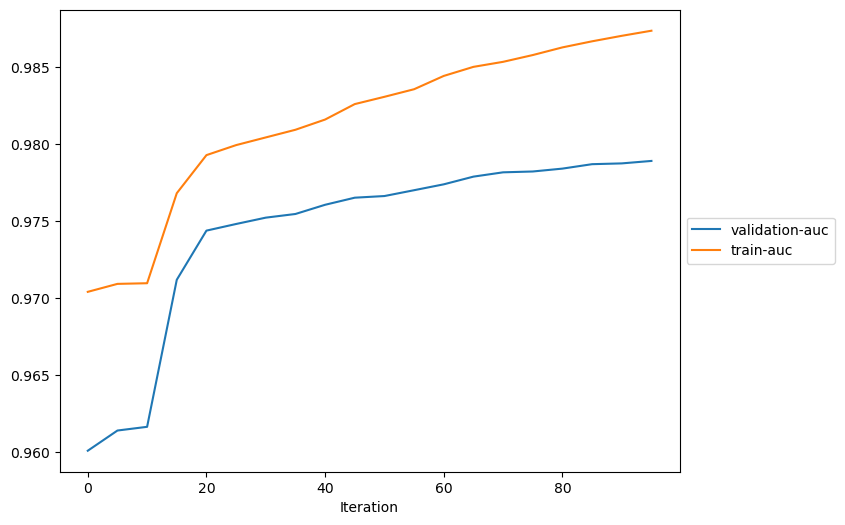

In [39]:
plot_collection(trial, "metrics")

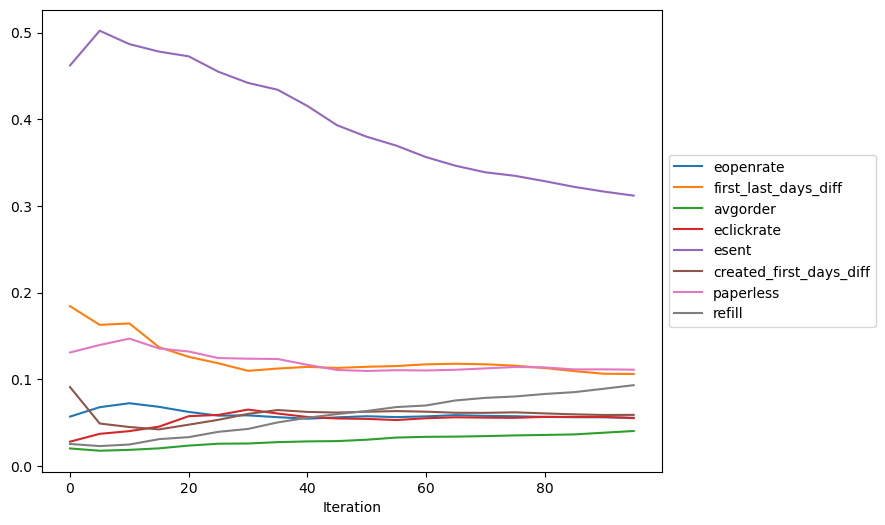

In [40]:
def plot_feature_importance(trial, importance_type="weight"):
    SUPPORTED_IMPORTANCE_TYPES = ["weight", "gain", "cover", "total_gain", "total_cover"]
    if importance_type not in SUPPORTED_IMPORTANCE_TYPES:
        raise ValueError(f"{importance_type} is not one of the supported importance types.")
    plot_collection(trial, "feature_importance", regex=f"feature_importance/{importance_type}/.*")


plot_feature_importance(trial, importance_type="cover")

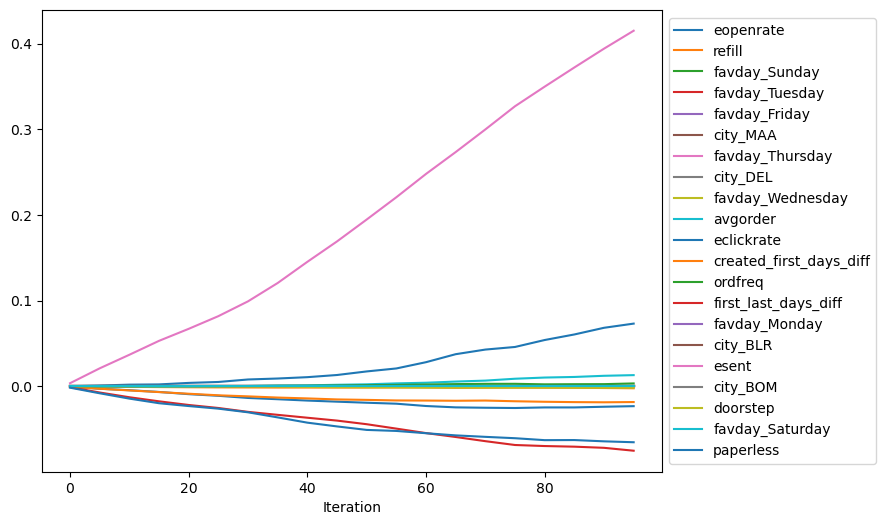

In [41]:
plot_collection(trial, "average_shap")

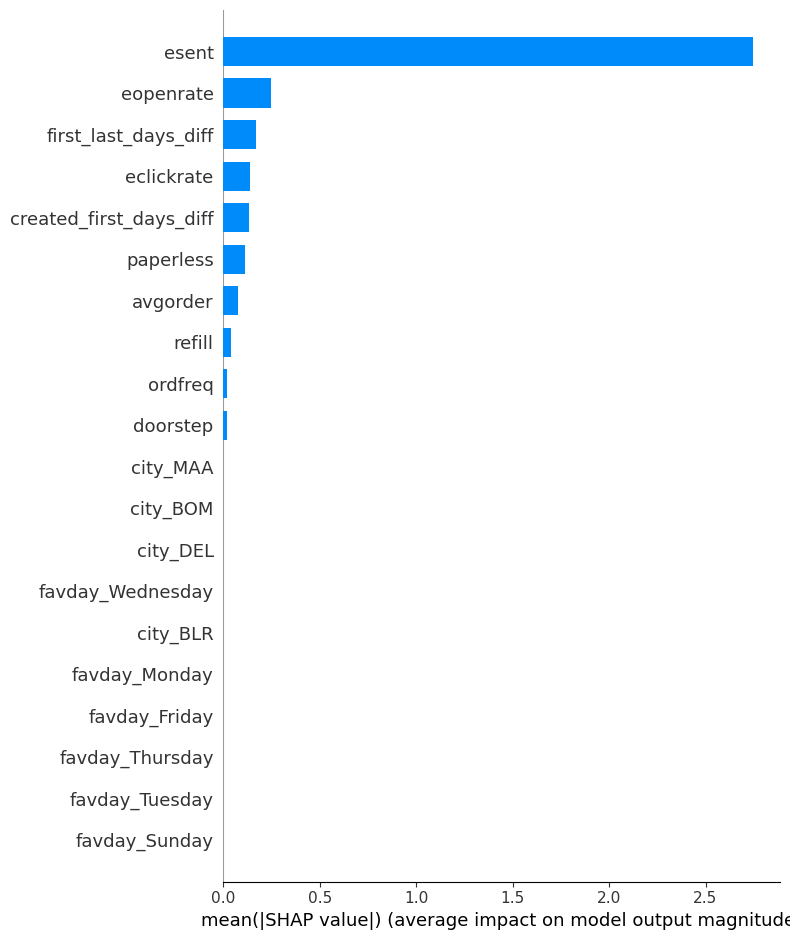

In [42]:
shap_values = trial.tensor("full_shap/f0").value(trial.last_complete_step)
shap_no_base = shap_values[:, :-1]
shap_base_value = shap_values[0, -1]
shap.summary_plot(shap_no_base, plot_type="bar", feature_names=feature_names)

In [43]:
shap_base_value

2.0351634

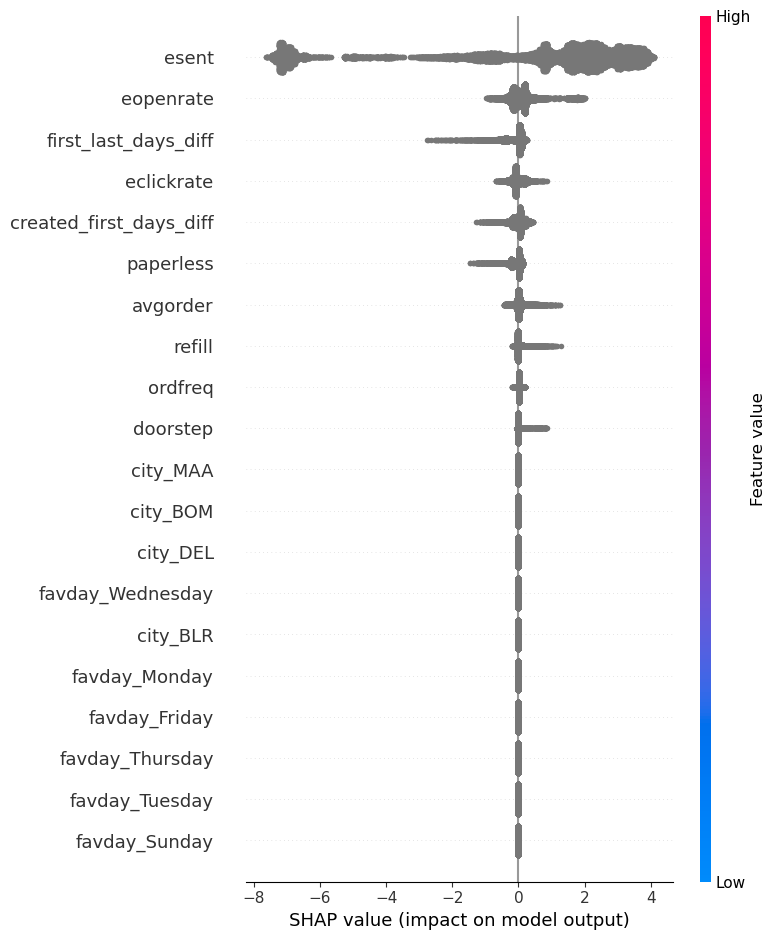

In [44]:
train_shap = pd.DataFrame(train[:,1:],columns=feature_names)
shap.summary_plot(shap_no_base, train_shap)